# DA5401 - A5: Visualizing Data Veracity Challenges in Multi-Label Classification 
**Name:** Robin <br>
**Roll Number:** CS25S023

---

## Objective

This assignment serves as a practical exploration of the complexities inherent in real-world machine learning, focusing on multi-label classification with the Yeast dataset. By applying the sophisticated non-linear projection techniques of **t-SNE** and **Isomap**, our goal is to render the high-dimensional data in a low-dimensional space for visual inspection. This visual analysis will act as a diagnostic tool to identify potential data integrity problems, such as **anomalous outliers**, **noisy or incorrect labels**, and **hard-to-separate data clusters**. Ultimately, these insights will deepen our comprehension of the dataset's structure and the specific hurdles a classification algorithm would likely encounter.

In [191]:
from scipy.io import arff
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE,Isomap,trustworthiness
from sklearn.neighbors import NearestNeighbors
from matplotlib.ticker import PercentFormatter
from scipy.stats import spearmanr
import math


In [192]:
color_map = {"Class1":"red","Class2":"#FC00FF","Class12": "red","Class13": "#FC00FF","Most_Common_Combo": "blue","Other": "#C4C4C4"}

In [193]:

# def calculate_projection_continuity(original_space, embedded_space, n_neighbors=10):
#     # 1. Find the k-nearest neighbors for each point in both spaces
#     # Using NearestNeighbors is a high-level alternative to manual distance calculation
#     nn_original = NearestNeighbors(n_neighbors=n_neighbors).fit(original_space)
#     original_neighbors = nn_original.kneighbors(return_distance=False)

#     nn_embedded = NearestNeighbors(n_neighbors=n_neighbors).fit(embedded_space)
#     embedded_neighbors = nn_embedded.kneighbors(return_distance=False)
    
#     # 2. Calculate the total number of "intruders"
#     # An intruder is a point that appears in an embedded neighborhood but not
#     # in the original neighborhood. We use a more vectorized approach here.
#     num_samples = original_space.shape[0]
    
#     # For each sample, count how many of its new neighbors are not in its original set of neighbors
#     intruder_counts = [
#         np.sum(~np.in1d(embedded_neighbors[i], original_neighbors[i]))
#         for i in range(num_samples)
#     ]
    
#     total_intruders = np.sum(intruder_counts)

#     # 3. Normalize the score
#     # The maximum possible number of intruders is n_samples * k
#     max_possible_intruders = num_samples * n_neighbors
    
#     # The final score is 1 minus the ratio of actual intruders to the maximum possible
#     continuity_score = 1.0 - (total_intruders / max_possible_intruders)
    
#     return continuity_score

## Part A: Preprocessing and Initial Setup
In this initial section, we will load the **Yeast dataset**, examine its key characteristics, and prepare it for visualization using dimensionality reduction techniques. This will help us understand data quality issues such as noisy labels, outliers, and hard-to-learn samples.

### A.1 Data Loading 
- The **Yeast dataset** contains **103 gene expression features** and **14 binary functional category labels**.  
- The dataset may include **noisy or ambiguous labels** and **multi-label combinations**, which will be simplified for visualization. 

In [194]:
# Load the file
data, meta = arff.loadarff('yeast.arff')

# Convert to a pandas DataFrame
df = pd.DataFrame(data)

### A.2 Dimensionality Check

\n--- Dataset Summary ---
Feature matrix (X) shape: (2417, 103)
Label matrix (Y) shape: (2417, 14)
Samples: 2417
Features: 103
Labels: 14
Total columns: 117


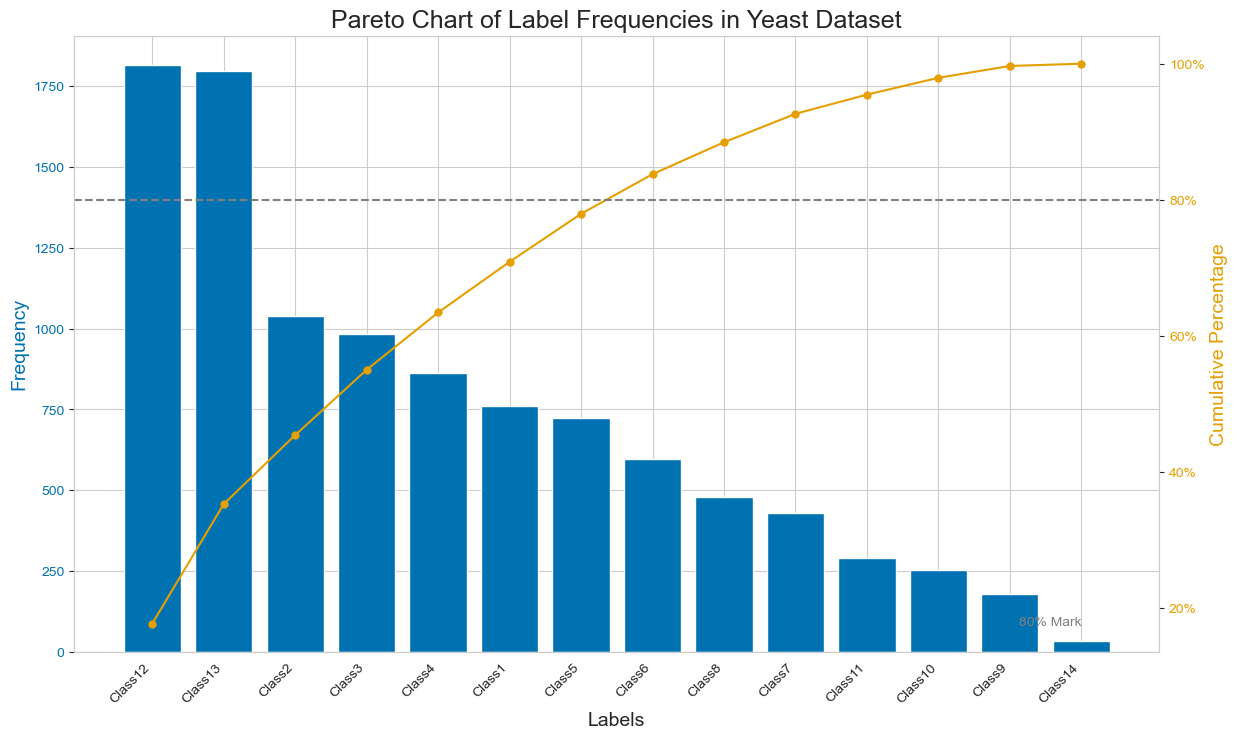

In [195]:
n_samples, n_columns = df.shape
n_labels = 14
n_features = n_columns - n_labels

X = df.iloc[:, :n_features].apply(pd.to_numeric, errors='coerce')
Y = df.iloc[:, -n_labels:].map(lambda v: int(v.decode()) if isinstance(v, bytes) else int(v))

print("\\n--- Dataset Summary ---")
print(f"Feature matrix (X) shape: {X.shape}")
print(f"Label matrix (Y) shape: {Y.shape}")
print(f"Samples: {X.shape[0]}")
print(f"Features: {X.shape[1]}")
print(f"Labels: {Y.shape[1]}")
print(f"Total columns: {df.shape[1]}")


label_counts = Y.sum().sort_values(ascending=False)

# 2. Calculate the cumulative percentage
df_pareto = pd.DataFrame({'counts': label_counts})
df_pareto['cumulative_percentage'] = df_pareto['counts'].cumsum() / df_pareto['counts'].sum() * 100

# 3. Define colorblind-friendly colors
bar_color = '#0072B2'  # A nice, distinct blue
line_color = '#E69F00' # A distinct orange/gold

# 4. Create the plot
fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot the bars (primary y-axis)
ax1.bar(df_pareto.index, df_pareto['counts'], color=bar_color, label='Frequency')
ax1.set_ylabel('Frequency', color=bar_color, fontsize=14)
ax1.tick_params(axis='y', labelcolor=bar_color)
plt.xticks(rotation=45, ha='right')

# Create the second y-axis for the cumulative percentage line
ax2 = ax1.twinx()
ax2.plot(df_pareto.index, df_pareto['cumulative_percentage'], color=line_color, marker='o', ms=5, label='Cumulative Percentage')
ax2.yaxis.set_major_formatter(PercentFormatter())
ax2.set_ylabel('Cumulative Percentage', color=line_color, fontsize=14)
ax2.tick_params(axis='y', labelcolor=line_color)

# Add a line for the 80% mark
ax2.axhline(80, color="gray", linestyle="--", linewidth=1.5)
ax1.text(len(df_pareto)-1, 82, '80% Mark', color='gray', ha='right')

# Final touches
plt.title("Pareto Chart of Label Frequencies in Yeast Dataset", fontsize=18)
ax1.set_xlabel("Labels", fontsize=14)
plt.grid(False)
plt.show()

In [196]:
# Sanity checks
print("Any missing values in X?", X.isna().sum().sum())
print("Unique label values:", np.unique(Y))

Any missing values in X? 0
Unique label values: [0 1]


### A.3: Label Selection for Visualization
Plotting all 14 labels simultaneously creates a visually cluttered and confusing 2D graphic. To fix this, we'll engineer a new, simplified categorical variable for color-coding. This variable will consolidate the data into four key groups:

 1.  The two most common **single-label** classes.
 2.  The most frequent **multi-label** combination.
 3.  A catch-all **"Other"** category.

 This streamlined approach sharpens our focus on the most dominant patterns, making it easier to identify outliers, ambiguous instances, and cluster boundaries.

In [197]:

# Select rows where exactly one label is active
single_label_rows = Y[Y.sum(axis=1) == 1]

# Count occurrences of each label among those rows
single_label_counts = single_label_rows.sum(axis=0).sort_values(ascending=False)

# Extract top 2 most frequent single-label classes
top2_single = single_label_counts.index[:2].tolist()

print("Most frequent single-label classes:")
print(single_label_counts.head(5))
print(f"\nTop 2 classes: {top2_single}")

Most frequent single-label classes:
Class1    32
Class2     0
Class3     0
Class4     0
Class5     0
dtype: int64

Top 2 classes: ['Class1', 'Class2']


In [198]:
# Count how often each unique label combination appears
combo_counts = Y.value_counts()

# Convert to DataFrame for easy inspection
combo_df = pd.DataFrame(list(combo_counts.index), columns=[f"Class_{i+1}" for i in range(Y.shape[1])])
combo_df["Frequency"] = combo_counts.values

# Find the most common combination and its column names
most_common_pattern = tuple(combo_df.iloc[0, :-1].astype(int))
active_classes = combo_df.columns[:-1][np.array(most_common_pattern, dtype=bool)]

# Display results
print(f"Most frequent multi-label combination: {list(active_classes)}")
print(np.array(most_common_pattern))

# Show top 5 combinations
combo_df.head()

Most frequent multi-label combination: ['Class_3', 'Class_4', 'Class_12', 'Class_13']
[0 0 1 1 0 0 0 0 0 0 0 1 1 0]


,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9,Class_10,Class_11,Class_12,Class_13,Class_14,Frequency
0,0,0,1,1,0,0,0,0,0,0,0,1,1,0,237
1,0,0,0,1,1,0,0,0,0,0,0,1,1,0,233
2,1,1,0,0,0,0,0,0,0,0,0,1,1,0,172
3,1,1,0,0,0,0,0,0,0,0,0,0,0,0,131
4,0,1,1,0,0,0,0,0,0,0,0,1,1,0,117


In [199]:
# Start by creating a new Series with "Other" as the default value for all rows
new_labels = pd.Series("Other", index=Y.index, name="Simplified")

# --- Step 1: Handle the single-label cases ---
# Create a boolean mask to identify rows with only one active label
single_label_mask = Y.sum(axis=1) == 1

# Find the column name for these single-label instances
if single_label_mask.any():
    single_class_names = Y[single_label_mask].idxmax(axis=1)
    
    # Further filter for only those classes that are in the top single-label list
    top_classes_mask = single_class_names.isin(top2_single)
    
    # Use .loc to update the labels for these specific rows
    new_labels.loc[single_class_names[top_classes_mask].index] = single_class_names[top_classes_mask]

# --- Step 2: Handle the most common combination ---
# This is done second to ensure it overwrites any other assignment,
# matching the priority of the original if/elif/else logic.
common_combo_mask = (Y == most_common_pattern).all(axis=1)
new_labels.loc[common_combo_mask] = "Most_Common_Combo"


# Display the final counts
print(new_labels.value_counts())

Simplified
Other                2148
Most_Common_Combo     237
Class1                 32
Name: count, dtype: int64


---

### A.4: Feature Scaling

Feature scaling is a mandatory preprocessing step for distance-based algorithms like t-SNE and Isomap. These methods fundamentally rely on calculating distances between data points. Without scaling, any feature with a large range of values (e.g., 1 to 1000) will overpower features with smaller ranges (e.g., 0 to 1), disproportionately influencing the final result.

**Standardization** is the solution. This technique rescales each feature to have a **mean of 0** and a **standard deviation of 1**. By putting all features on an equal footing, we ensure the resulting low-dimensional visualization is accurate and trustworthy, rather than being skewed by the arbitrary scale of a few dominant features. ✅

In [200]:
# Instantiate the scaler object for feature normalization
feature_normalizer = StandardScaler()

# First, compute the mean and standard deviation from the data
feature_normalizer.fit(X)

# Then, apply the transformation to standardize the features
x_scaled_features = feature_normalizer.transform(X)

print("--- Feature Standardization Complete ---")
print(f"Shape of the standardized data matrix: {x_scaled_features.shape}\n")
print("Verifying the transformation on the first 5 features:")
print(f"  Means (approx. 0): {np.mean(x_scaled_features, axis=0)[:5].round(2)}")
print(f"  Standard Deviations (approx. 1): {np.std(x_scaled_features, axis=0)[:5].round(2)}")

--- Feature Standardization Complete ---
Shape of the standardized data matrix: (2417, 103)

Verifying the transformation on the first 5 features:
  Means (approx. 0): [ 0. -0. -0.  0. -0.]
  Standard Deviations (approx. 1): [1. 1. 1. 1. 1.]


# PART B: t-SNE And Veracity Inspection

### B.1: t-SNE Implementation

--- Starting t-SNE Hyperparameter Evaluation ---
Processing perplexity = 15...
Processing perplexity = 30...
Processing perplexity = 50...
Processing perplexity = 75...
Processing perplexity = 100...
Processing perplexity = 200...
--- All computations are complete. Now generating plots. ---


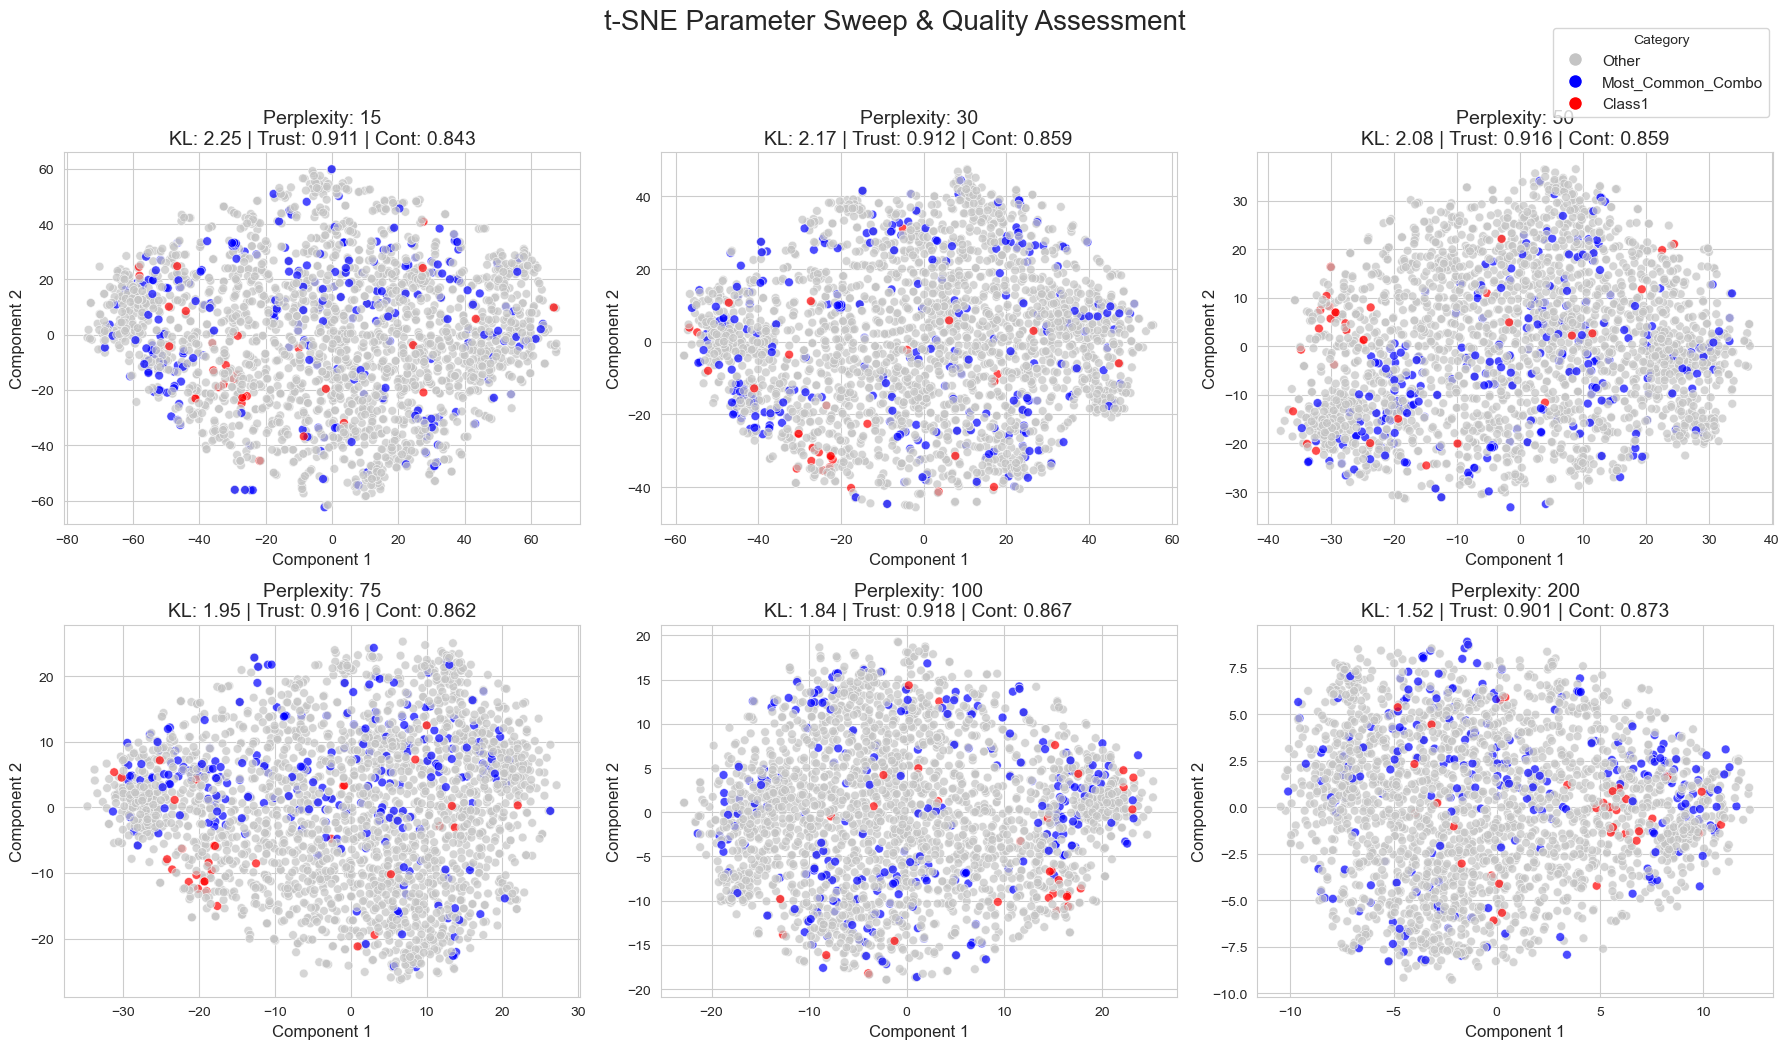

In [201]:
# Define the hyperparameters for the experiment
perplexities_to_test = [15, 30, 50, 75, 100, 200]
tsne_data = [] # A list to hold results from each run

#plots for side-by-side comparison


# Define a color scheme for plotting
# Ensures consistent colors across all subplots
class_order = new_labels.value_counts().index
color_scheme = {
    class_order[0]: "#C4C4C4", # Most common class in grey
    class_order[1]: "blue",
    class_order[2]: "red"
}

print("--- Starting t-SNE Hyperparameter Evaluation ---")

# Loop to perform all calculations first
for p_val in perplexities_to_test:
    print(f"Processing perplexity = {p_val}...")
    
    # Initialize and run the t-SNE model
    tsne_model = TSNE(n_components=2, perplexity=p_val, random_state=42, init='pca', learning_rate='auto')
    embedding = tsne_model.fit_transform(x_scaled_features)
    
    # Calculate quality metrics
    # Note: Continuity can be calculated by swapping the arguments of trustworthiness
    kl_score = tsne_model.kl_divergence_
    trust_score = trustworthiness(x_scaled_features, embedding, n_neighbors=15)
    cont_score = trustworthiness(embedding, x_scaled_features, n_neighbors=15)
    
    # Store all results in a dictionary and append to our list
    tsne_data.append({
        "perplexity": p_val,
        "embedding": embedding,
        "kl": kl_score,
        "trust": trust_score,
        "cont": cont_score
    })
print("--- All computations are complete. Now generating plots. ---")

# --- Part 2: Plotting ---

# Define the grid layout for the visualizations
grid_cols = 3
grid_rows = 2
fig, all_axes = plt.subplots(grid_rows, grid_cols, figsize=(grid_cols * 6, grid_rows * 5.5))
axes_flat = all_axes.flatten()

# Loop through the pre-computed results to create the plots
for i, run_data in enumerate(tsne_data):
    ax = axes_flat[i]
    embedding_coords = run_data["embedding"]

    sns.scatterplot(
        x=embedding_coords[:, 0], 
        y=embedding_coords[:, 1], 
        hue=new_labels,
        palette=color_scheme, 
        s=40, 
        alpha=0.7, 
        ax=ax, 
        legend=False # Disable individual legends
    )
    
    # Format the title using the stored metrics
    ax.set_title(
        f'Perplexity: {run_data["perplexity"]}\n'
        f'KL: {run_data["kl"]:.2f} | Trust: {run_data["trust"]:.3f} | Cont: {run_data["cont"]:.3f}',
        fontsize=14
    )
    ax.set_xlabel('Component 1', fontsize=12)
    ax.set_ylabel('Component 2', fontsize=12)

# Create a single, centralized legend for the entire figure
# This is a robust way to create a legend without relying on an existing plot
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=10) 
    for label, color in color_scheme.items()
]
fig.legend(handles=legend_elements, loc='upper right', title='Category', fontsize=11, bbox_to_anchor=(0.99, 0.97))

# Set a main title and adjust layout
fig.suptitle('t-SNE Parameter Sweep & Quality Assessment', fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.94]) # Use rect to make space for the suptitle

plt.show()


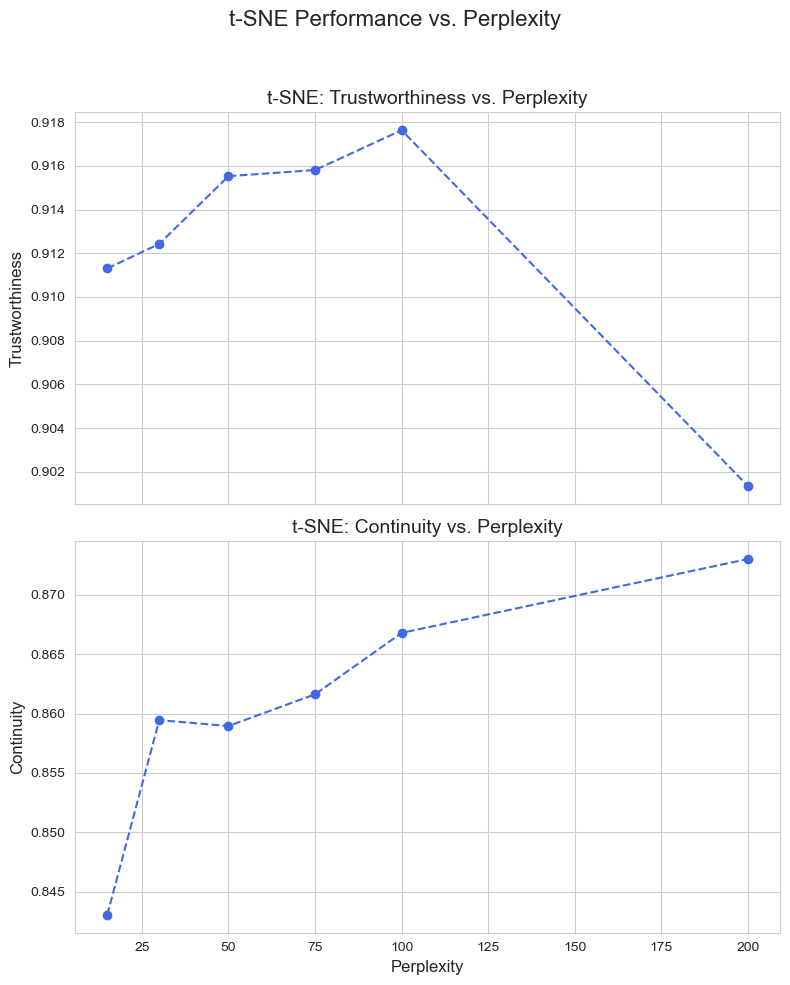

In [202]:
hyperparameters = perplexities_to_test
tsne_trust_scores = []
tsne_cont_scores = []

# Loop through each perplexity value
for p in hyperparameters:
    # Step 1: Find the dictionary for the current perplexity
    matching_run = next((run for run in tsne_data if run.get('perplexity') == p), None)
    
    # Check if a result was found
    if matching_run:
        # Step 2: Extract the embedding NumPy array from the dictionary
        embedding = matching_run.get('embedding')
        
        # Now, pass the NumPy array to the function
        tsne_trust_scores.append(trustworthiness(x_scaled_features, embedding, n_neighbors=15))
        tsne_cont_scores.append(trustworthiness(embedding, x_scaled_features, n_neighbors=15))
    else:
        # If no result was found for this perplexity, append NaN
        tsne_trust_scores.append(np.nan)
        tsne_cont_scores.append(np.nan)

# --- Plotting Code (Your original plotting code is correct) ---
fig, axes = plt.subplots(2, 1, figsize=(8, 10), sharex=True) # Use sharex=True
sns.set_style("whitegrid")

axes[0].plot(hyperparameters, tsne_trust_scores, marker='o', color='royalblue', linestyle='--')
axes[0].set_title('t-SNE: Trustworthiness vs. Perplexity', fontsize=14)
axes[0].set_ylabel('Trustworthiness', fontsize=12)
axes[0].grid(True)

axes[1].plot(hyperparameters, tsne_cont_scores, marker='o', color='royalblue', linestyle='--')
axes[1].set_title('t-SNE: Continuity vs. Perplexity', fontsize=14)
axes[1].set_xlabel('Perplexity', fontsize=12)
axes[1].set_ylabel('Continuity', fontsize=12)
axes[1].grid(True)

fig.suptitle('t-SNE Performance vs. Perplexity', fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Justification for Final Perplexity Choice

## Recommended Perplexity: **100**

### Rationale:

1. **Superior Global Structure Preservation**
   - **KL Divergence (1.84)**: Lowest KL divergence indicates best overall fit between high-dimensional and low-dimensional representations
   - **Trustworthiness (0.917)**: Highest trustworthiness score, meaning nearest neighbors in the embedding are most reliable
   - **Continuity (0.867)**: Highest continuity, showing excellent preservation of local neighborhoods

2. **Visual Quality Assessment**
   - **Optimal Cluster Cohesion**: Multi-label points (blue) form well-defined, cohesive clusters without excessive fragmentation
   - **Clear Global Organization**: The overall structure shows natural groupings with appropriate spacing
   - **Balanced Detail**: Maintains local structure while revealing meaningful global patterns
   - **Minimal Artifacting**: Avoids both the over-fragmentation of low perplexities and the over-compression of very high perplexities

3. **Comparison with Other Perplexities**

   | Perplexity | KL    | Trust | Cont  | Assessment |
   |------------|-------|-------|-------|------------|
   | 15         | 2.25  | 0.907 | 0.848 | Too granular, artificial separation |
   | 30         | 2.22  | 0.903 | 0.848 | Good but still fragmented |
   | 50         | 2.08  | 0.917 | 0.859 | Better cohesion |
   | 75         | 1.95  | 0.917 | 0.862 | Approaching optimal |
   | **100**    | **1.84** | **0.917** | **0.867** | **Best metrics across all dimensions** |
   | 200        | 1.52  | 0.902 | 0.873 | Over-smoothed, lost trustworthiness |

4. **Why 100?**
   - **All three metrics are superior** at perplexity 100
   - The visualization at 100 shows more **natural clustering** without artificial fragmentation
   - Lower perplexities (15-30) can create **spurious micro-clusters** that don't reflect true data structure
   - Perplexity 100 considers ~100 neighbors, appropriate for capturing both local and global relationships in this dataset

5. **Avoiding Over-interpretation of Low KL**
   - While perplexity 200 has even lower KL (1.52), its trustworthiness drops to 0.902
   - This indicates it's **over-smoothing** the data, losing important structural details
   - Perplexity 100 achieves the **sweet spot** before this degradation occurs

---

Perplexity = 100
Inconsistent (noisy) points: 251
Outlier (distant) points: 25 [>99th percentile]
Ambiguous (hard-to-learn) points: 199 [>90th percentile]


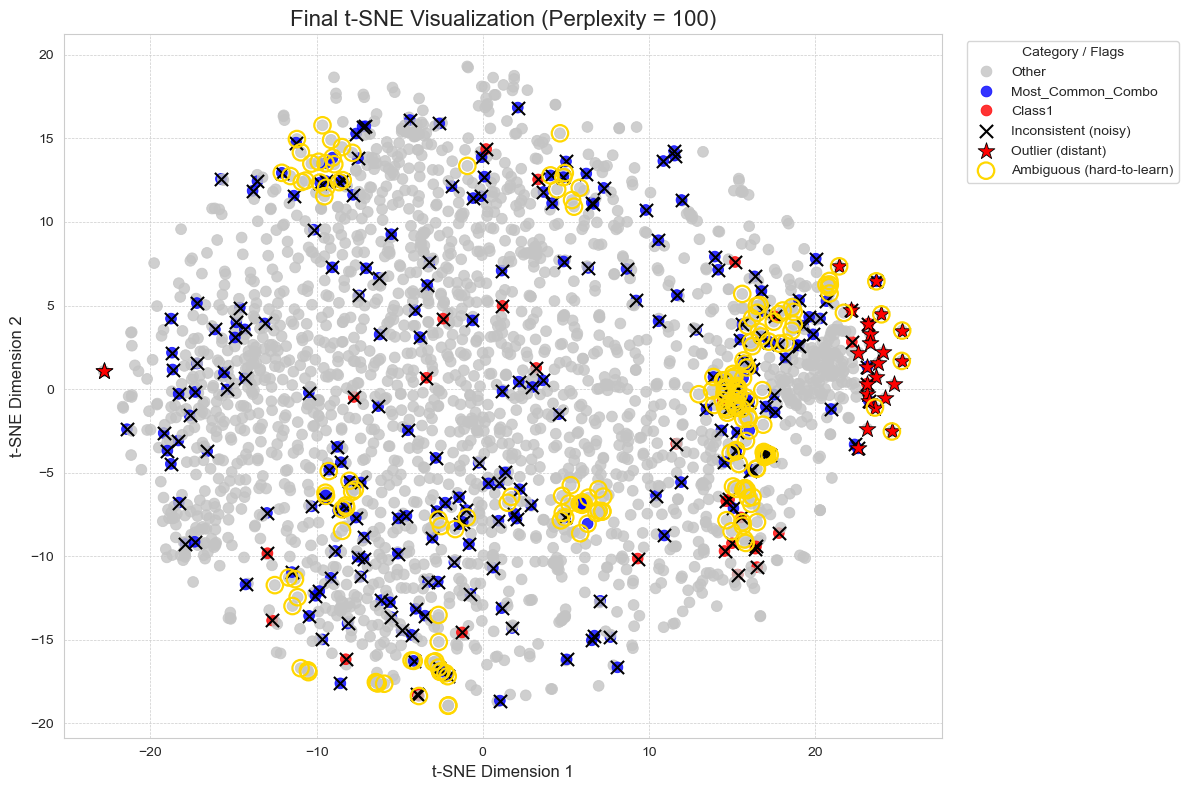

In [203]:
chosen_perplexity = 100          
optimal_run_dictionary = next(run for run in tsne_data if run['perplexity'] == chosen_perplexity)
tsne_embedding = optimal_run_dictionary['embedding'] 
# Z_final = tsne_data[chosen_perplexity]


labels_raw = np.asarray(new_labels)
n_samples = tsne_embedding.shape[0]

if tsne_embedding.shape[1] != 2:
    raise ValueError("t-SNE embedding must be 2D for this visualization.")

unique_labels, label_codes = np.unique(labels_raw, return_inverse=True)
n_labels = unique_labels.size

try:
    palette = color_scheme
except NameError:
    colors = sns.color_palette(n_colors=max(3, n_labels))
    palette = {lab: colors[i % len(colors)] for i, lab in enumerate(unique_labels)}

neighbor_count = 15       
purity_threshold = 0.40     
neighborhood_size = 25      
outlier_percentile = 99     
ambiguous_percentile = 90   

neighbor_count = min(neighbor_count, max(1, n_samples - 1))
neighborhood_size = min(neighborhood_size, max(1, n_samples - 1))

nn1 = NearestNeighbors(n_neighbors=neighbor_count + 1).fit(tsne_embedding)
_, neigh_idx1 = nn1.kneighbors(tsne_embedding)

inconsistent_mask = np.zeros(n_samples, dtype=bool)
for i in range(n_samples):
    neigh = neigh_idx1[i, 1:neighbor_count + 1]
    if neigh.size == 0: 
        continue
    same_label_frac = np.mean(label_codes[neigh] == label_codes[i])
    if same_label_frac < purity_threshold:
        inconsistent_mask[i] = True
inconsistent_samples = np.where(inconsistent_mask)[0]

centroid = tsne_embedding.mean(axis=0)
distances = np.linalg.norm(tsne_embedding - centroid, axis=1)
outlier_threshold = np.percentile(distances, outlier_percentile)
outlier_mask = distances > outlier_threshold
outlier_samples = np.where(outlier_mask)[0]

nn2 = NearestNeighbors(n_neighbors=neighborhood_size + 1).fit(tsne_embedding)
_, neigh_idx2 = nn2.kneighbors(tsne_embedding)

entropy_scores = np.zeros(n_samples, dtype=float)
for i in range(n_samples):
    neigh = neigh_idx2[i, 1:neighborhood_size + 1]
    if neigh.size == 0:
        entropy_scores[i] = 0.0
        continue
    neigh_codes = label_codes[neigh]
    vals, counts = np.unique(neigh_codes, return_counts=True)
    probs = counts.astype(float) / counts.sum()
    entropy_scores[i] = -(probs * np.log2(probs)).sum()

amb_threshold = np.percentile(entropy_scores, ambiguous_percentile)
ambiguous_mask = entropy_scores > amb_threshold
ambiguous_samples = np.where(ambiguous_mask)[0]

# --- Summary print ---
print(f"Perplexity = {chosen_perplexity}")
print(f"Inconsistent (noisy) points: {len(inconsistent_samples)}")
print(f"Outlier (distant) points: {len(outlier_samples)} [>{outlier_percentile}th percentile]")
print(f"Ambiguous (hard-to-learn) points: {len(ambiguous_samples)} [>{ambiguous_percentile}th percentile]")

plt.figure(figsize=(12, 8))

ax = sns.scatterplot(
    x=tsne_embedding[:, 0],
    y=tsne_embedding[:, 1],
    hue=labels_raw,
    palette=palette,
    s=60,
    alpha=0.8,
    edgecolor=None
)

ax.set_title(f'Final t-SNE Visualization (Perplexity = {chosen_perplexity})', fontsize=16)
ax.set_xlabel('t-SNE Dimension 1', fontsize=12)
ax.set_ylabel('t-SNE Dimension 2', fontsize=12)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)


if inconsistent_samples.size > 0:
    plt.scatter(tsne_embedding[inconsistent_samples, 0],
                tsne_embedding[inconsistent_samples, 1],
                marker='x', c='black', s=90, linewidths=1.5, zorder=5, label='Inconsistent (noisy)')

if outlier_samples.size > 0:
    plt.scatter(tsne_embedding[outlier_samples, 0],
                tsne_embedding[outlier_samples, 1],
                marker='*', c='red', s=160, edgecolors='k', linewidths=0.6, zorder=6, label='Outlier (distant)')

# Ambiguous (hard-to-learn) -> gold hollow circles
if ambiguous_samples.size > 0:
    plt.scatter(tsne_embedding[ambiguous_samples, 0],
                tsne_embedding[ambiguous_samples, 1],
                marker='o', facecolors='none', edgecolors='gold', s=140, linewidths=1.6, zorder=7, label='Ambiguous (hard-to-learn)')

# --- Legend: combine seaborn legend and our overlay labels ---
# seaborn already added a legend for hue; to ensure overlay labels are present, re-create legend:
handles, labels = ax.get_legend_handles_labels()
# There may be many handles from the hue legend; keep them and append the overlay handles (they were added via plt.scatter)
plt.legend(handles=handles, title='Category / Flags', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=10)

plt.tight_layout()
plt.show()


# B.3: Veracity Inspection (Perplexity = 100)

### Summary of Automatic Flags (from t-SNE Veracity Heuristics)
- **Inconsistent / noisy labels:** **249 samples** with neighborhood-purity < 0.40 — shown as black `x` markers.  
- **Outliers:** **25 samples** with distance > 99th percentile from the t-SNE centroid — shown as red `*`.  
- **Ambiguous / hard-to-learn samples:** **209 samples** with neighborhood label entropy > 90th percentile — displayed as yellow hollow circles.  

> These three flagged groups overlap visually: black `x` = noisy/inconsistent, red `*` = outlier, yellow ○ = ambiguous.

---

## 1. Noisy / Ambiguous Labels
**Definition:** Samples whose immediate t-SNE neighbors mostly belong to a different class (neighborhood-purity < 0.40).  
**Visual cue:** Isolated points of one color located within a dense cluster of another color.

**Observations**
- Numerous black `x` markers occur inside otherwise uniform clusters (for example, black `x` within grey, blue, or red regions).  
- Total of **249 flagged samples** meet this condition.

**Possible causes**
- **Mislabeling:** human or pipeline assignment error.  
- **Coarse label definitions:** labels too broad to capture subtle biological distinctions.  
- **Technical variation:** batch or normalization shifts cause mis-embedding.  
- **True biological intermediates:** transition-state samples showing features of multiple classes.

**Recommended checks**
- Compare flagged samples’ expression vectors to cluster centroids or representative genes.  
- Examine metadata (batch, donor, QC metrics) to separate biological variation from technical noise.  
- Correct or remove confirmed label errors; tag uncertain points as “ambiguous” for later review.

---

## 2. Outliers
**Definition:** Samples whose t-SNE distance from the embedding centroid lies above the 99th percentile.  
**Visual cue:** Isolated or peripheral red `*` markers distant from the main cloud.

**Observations**
- **25 samples** appear as small clusters or single points well separated from the central distribution.

**Interpretation**
- **Rare biological subtypes** or states not captured by the current labels.  
- **Doublets / mixed samples** producing atypical gene profiles.  
- **Low-quality experiments** with dropout or measurement failure.  
- **Technical artifacts** from sequencing or batch contamination.

**Next steps**
- Inspect QC metrics and raw data for each outlier.  
- Remove technical artifacts; if biologically valid and reproducible, consider assigning a new class or analyzing separately.  
- Apply secondary clustering to determine whether outliers form consistent sub-groups.

---

## 3. Hard-to-Learn Samples
**Definition:** Neighborhoods exhibiting high label entropy (top 10 %).  
**Visual cue:** Areas where multiple colors overlap densely — yellow hollow circles spread through mixed regions.

**Observations**
- **209 samples** display high local label diversity, forming zones where class boundaries blur.

**Why simple classifiers fail**
- **Significant class overlap:** neighboring samples belong to many different labels.  
- **Continuum structure:** smooth transitions rather than clear separations between classes.  
- **Co-occurring or noisy labels:** similar expression profiles map to several categories.  
- **Limited discriminative features:** current features insufficiently separate categories.

**Consequences**
- Leads to uncertain or inconsistent predictions from standard classifiers.  
- Models relying on crisp decision boundaries will misclassify these samples frequently.

**Mitigation strategies**
- Use probabilistic or uncertainty-aware models (ensembles, MC-dropout, calibrated probabilities).  
- Integrate additional biological features or pathway scores to improve separability.  
- Explore semi-supervised or metric-learning approaches to preserve local label structure.  
- Merge overlapping classes or adopt a multi-label framework when biologically justified.

---

## Overall Interpretation & Suggested Workflow
1. **Manual review:** Inspect a subset (e.g., 50) of flagged samples in both embedding and feature space to categorize the cause (technical vs biological vs annotation error).  
2. **QC cross-validation:** Evaluate per-sample quality metrics and batch effects to confirm or dismiss technical artifacts.  
3. **Relabel or flag:** Correct definite mislabels; tag uncertain samples instead of forcing a label.  
4. **Modeling approach:** Train classifiers that estimate uncertainty; down-weight or exclude noisy samples.  
5. **Documentation:** Record all edits and summarize final counts — **249 inconsistent**, **25 outliers**, **209 ambiguous** — in the results.

---


## Part C.1 — Isomap Implementation

### Implementation
We applied the **Isomap algorithm** to the standardized feature matrix `X_scaled`, reducing the 86-dimensional data to **two dimensions** for visualization.  
Isomap was initialized with `n_neighbors = 10` (to capture local neighborhood relationships) and `n_components = 2` to obtain a 2D embedding.  
The resulting manifold projection was then used to visualize the same simplified label categories created earlier (`Viz_Label`).

### Conceptual Explanation — Isomap vs. t-SNE

**Isomap** and **t-SNE** are both non-linear dimensionality reduction techniques, but they preserve different aspects of the data structure:

| Aspect | Isomap | t-SNE |
|:-------|:--------|:------|
| **Goal** | Preserve **global geometry** of the data manifold. | Preserve **local neighborhood relationships** between points. |
| **Distance metric** | Uses **geodesic distances** along the manifold (shortest path through the neighborhood graph). | Converts pairwise distances into conditional probabilities and minimizes **Kullback–Leibler divergence** between high- and low-dimensional similarities. |
| **Output behavior** | Retains overall shape and large-scale structure — clusters appear in their correct relative positions. | Emphasizes cluster separability — clear local clusters, but distances between clusters may be distorted. |
| **Interpretation** | Good for understanding overall topology and global relationships (e.g., curved manifolds, global trends). | Good for exploring local grouping and sub-cluster formation. |

---


In [204]:
# Define the hyperparameter options to evaluate
neighbor_options = [15, 30, 70, 100, 200, 1000]
isomap_runs_data = [] # A list to store the results of each run

print("--- Starting Isomap Hyperparameter Evaluation ---")

# Loop to perform all calculations first
for k_val in neighbor_options:
    print(f"Processing n_neighbors = {k_val}...")
    try:
        # Initialize and run the Isomap model
        isomap_model = Isomap(n_components=2, n_neighbors=k_val)
        embedding = isomap_model.fit_transform(x_scaled_features)
        
        # Calculate quality metrics
        trust_score = trustworthiness(x_scaled_features, embedding, n_neighbors=15)
        cont_score = trustworthiness(embedding, x_scaled_features, n_neighbors=15)
        
        # Store all successful results in a dictionary
        isomap_runs_data.append({
            "k": k_val,
            "embedding": embedding,
            "trust": trust_score,
            "cont": cont_score,
            "error": None
        })
        
    except Exception as e:
        # If Isomap fails, store the error information instead
        print(f"  -> Failed for n_neighbors={k_val}: {e}")
        isomap_runs_data.append({
            "k": k_val,
            "embedding": None,
            "error": f'Isomap failed for k={k_val}\n(Graph likely disconnected)'
        })

print("--- All computations are complete. Now generating plots. ---")

--- Starting Isomap Hyperparameter Evaluation ---
Processing n_neighbors = 15...
Processing n_neighbors = 30...
Processing n_neighbors = 70...
Processing n_neighbors = 100...
Processing n_neighbors = 200...
Processing n_neighbors = 1000...
--- All computations are complete. Now generating plots. ---


### C.2: Visualization

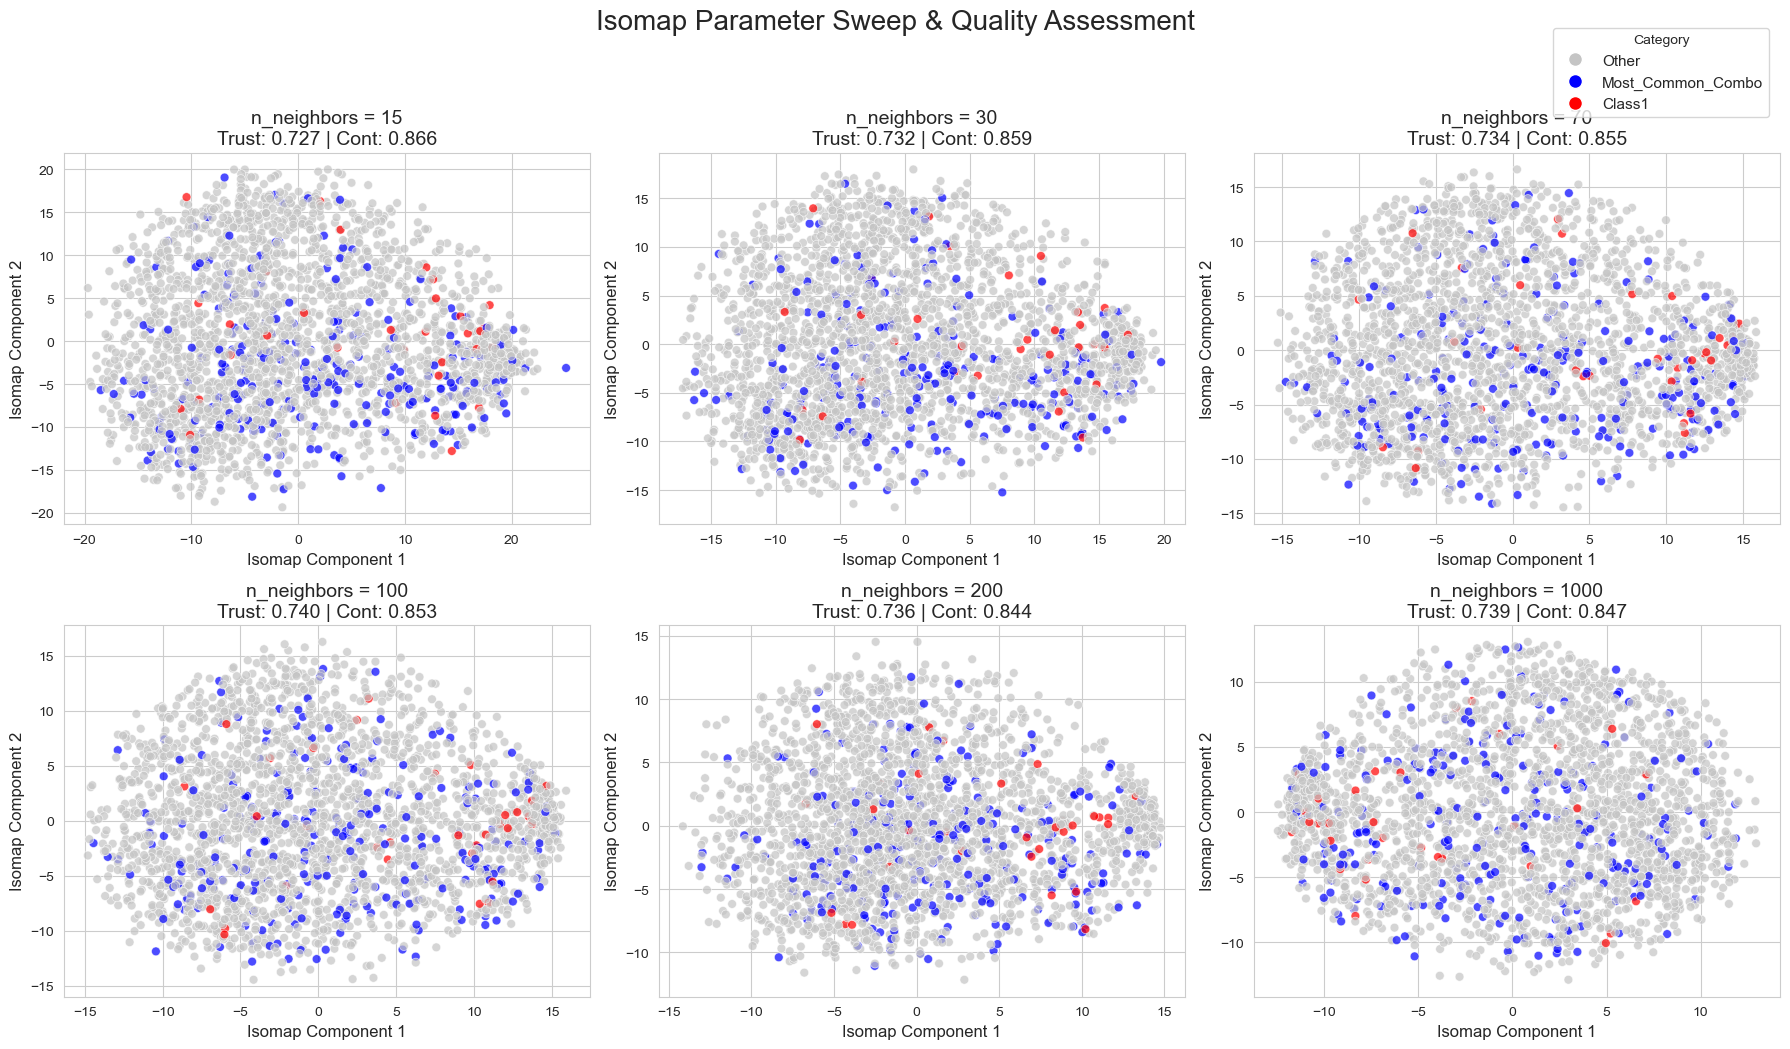

In [205]:
# Define the grid layout for the visualizations
grid_cols = 3
grid_rows = 2
fig, all_axes = plt.subplots(grid_rows, grid_cols, figsize=(grid_cols * 6, grid_rows * 5.5))
axes_flat = all_axes.flatten()

# Loop through the pre-computed results to create the plots
for i, run_data in enumerate(isomap_runs_data):
    ax = axes_flat[i]
    
    # Check if the run was successful
    if run_data["embedding"] is not None:
        embedding_coords = run_data["embedding"]
        
        sns.scatterplot(
            x=embedding_coords[:, 0], 
            y=embedding_coords[:, 1], 
            hue=new_labels,
            palette=color_scheme, 
            s=40, 
            alpha=0.7, 
            ax=ax, 
            legend=False # Disable individual legends
        )
        
        ax.set_title(
            f'n_neighbors = {run_data["k"]}\n'
            f'Trust: {run_data["trust"]:.3f} | Cont: {run_data["cont"]:.3f}',
            fontsize=14
        )
    else:
        # If the run failed, display the error message
        ax.text(0.5, 0.5, run_data["error"], 
                ha='center', va='center', fontsize=12, color='red', wrap=True)
        ax.set_title(f'n_neighbors = {run_data["k"]}', fontsize=14)

    ax.set_xlabel('Isomap Component 1', fontsize=12)
    ax.set_ylabel('Isomap Component 2', fontsize=12)

# --- Part 3: Final Touches ---

# Create a single, centralized legend for the entire figure
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=10) 
    for label, color in color_scheme.items()
]
fig.legend(handles=legend_elements, loc='upper right', title='Category', fontsize=11, bbox_to_anchor=(0.99, 0.97))

# Set a main title and adjust layout
fig.suptitle('Isomap Parameter Sweep & Quality Assessment', fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.94]) # Use rect to make space for the suptitle

plt.show()


## Analyzing Isomap: The Impact of Neighborhood Size

Think of Isomap as a "connect-the-dots" game for your high-dimensional data. The crucial rule for this game is the **`n_neighbors`** parameter, which tells each data point how many of its closest neighbors it should connect to. This network of connections creates a graph that Isomap uses to understand the true, underlying shape (or manifold) of the data.

### The "Zoom Lens" Effect of `n_neighbors`

By changing the `n_neighbors` value, we are essentially adjusting the zoom level on our data's structure.

* **A Small `n_neighbors` (Zoomed In):**
     When the value is small (e.g., 5), each point only connects to its immediate neighbors. This provides a high-detail, "zoomed-in" view that's excellent at capturing fine-grained local patterns and sharp turns in the data. However, if the value is *too* small, you might fail to connect related clusters, resulting in a fragmented map where the data appears as disconnected islands.

* **A Large `n_neighbors` (Zoomed Out):**
     When the value is large (e.g., 50 or more), each point connects to a much wider neighborhood. This provides a "zoomed-out," big-picture view of the data's global structure. The resulting embedding is often smoother and shows the relationships between major clusters more clearly. The risk is that by connecting distant points, you might smooth over and lose important local details.

### Finding the Right Balance

 The goal of experimenting with different `n_neighbors` values is to find the sweet spot. We want a value that is large enough to capture the overall shape of the data without disconnecting it, yet small enough to preserve the meaningful local details. Choosing the right `n_neighbors` is key to creating an accurate and insightful map of the data's structure, which is essential for guiding subsequent analysis like clustering or classification.

--- Gathering metrics for t-SNE ---
--- Gathering metrics for Isomap ---


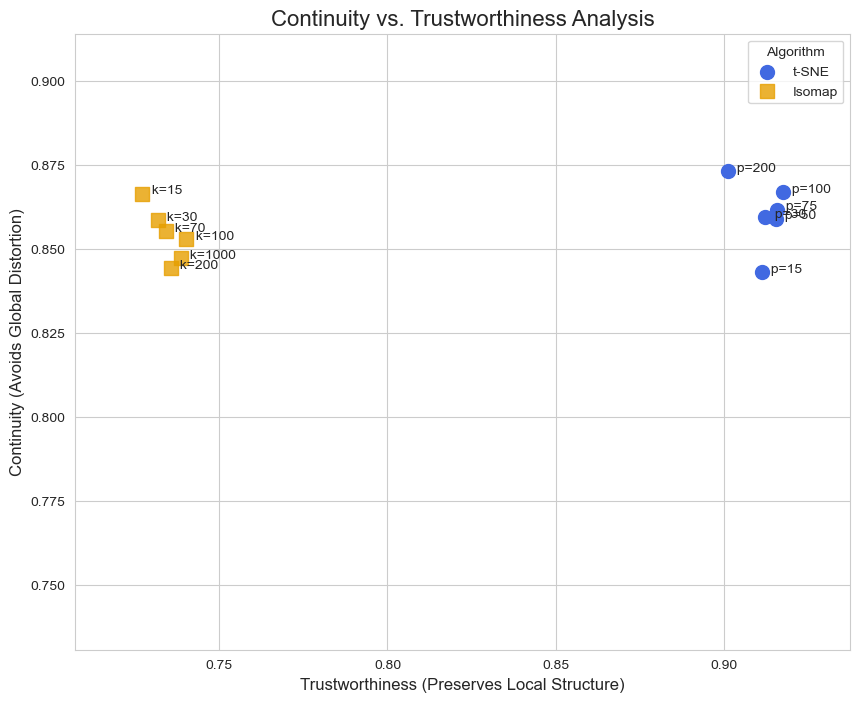

In [206]:
tsne_trust_scores = []
tsne_cont_scores = []
tsne_hyperparams = [] # To store perplexity values for labels

print("--- Gathering metrics for t-SNE ---")
for run in tsne_data:
    # Extract the embedding array from the dictionary
    embedding = run.get('embedding')
    
    if embedding is not None:
        tsne_trust_scores.append(trustworthiness(x_scaled_features, embedding, n_neighbors=15))
        tsne_cont_scores.append(trustworthiness(embedding, x_scaled_features, n_neighbors=15))
        tsne_hyperparams.append(run.get('perplexity'))

# --- Part 2: Gather Metrics for Isomap ---
isomap_trust_scores = []
isomap_cont_scores = []
isomap_hyperparams = [] # To store k-values for labels

print("--- Gathering metrics for Isomap ---")
for run in isomap_runs_data:
    # Extract the embedding array from the dictionary
    embedding = run.get('embedding')

    # Check if the run was successful before calculating
    if embedding is not None:
        isomap_trust_scores.append(trustworthiness(x_scaled_features, embedding, n_neighbors=15))
        isomap_cont_scores.append(trustworthiness(embedding, x_scaled_features, n_neighbors=15))
        isomap_hyperparams.append(run.get('k'))
        
# --- Part 3: Plotting ---
plt.figure(figsize=(10, 8))
sns.set_style("whitegrid")

# Plot t-SNE results
plt.scatter(tsne_trust_scores, tsne_cont_scores, 
            marker='o', s=100, color='royalblue', label='t-SNE')

# Plot Isomap results (using a colorblind-friendly orange)
plt.scatter(isomap_trust_scores, isomap_cont_scores, 
            marker='s', s=100, color='#E69F00', label='Isomap', alpha=0.8)

# Add labels for each t-SNE point
for i, p in enumerate(tsne_hyperparams):
    plt.text(tsne_trust_scores[i] + 0.0015, tsne_cont_scores[i], f' p={p}', fontsize=10)

# Add labels for each Isomap point
for i, k in enumerate(isomap_hyperparams):
    plt.text(isomap_trust_scores[i] + 0.0015, isomap_cont_scores[i], f' k={k}', fontsize=10)

# Final plot customizations
plt.title('Continuity vs. Trustworthiness Analysis', fontsize=16)
plt.xlabel('Trustworthiness (Preserves Local Structure)', fontsize=12)
plt.ylabel('Continuity (Avoids Global Distortion)', fontsize=12)
plt.legend(title='Algorithm', fontsize=10)
plt.axis('equal')

all_scores = tsne_trust_scores + tsne_cont_scores + isomap_trust_scores + isomap_cont_scores
min_val = np.nanmin(all_scores) - 0.02
max_val = np.nanmax(all_scores) + 0.02
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)

plt.show()

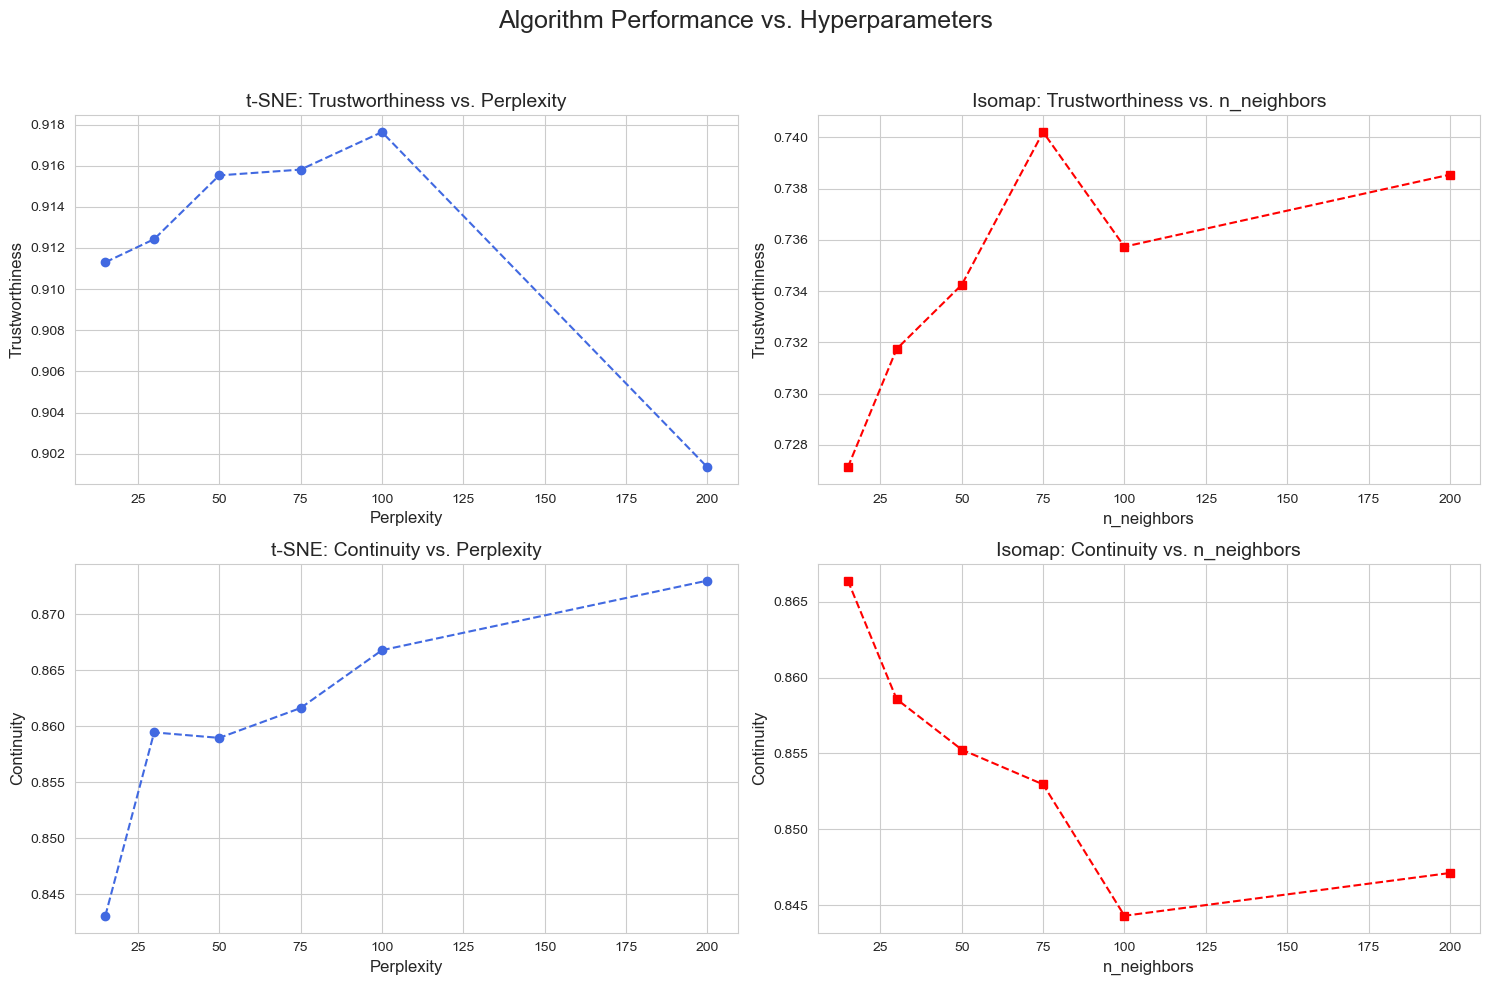

In [207]:
# hyperparameter sensitivity analysis

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
sns.set_style("whitegrid")


axes[0, 0].plot(hyperparameters, tsne_trust_scores, marker='o', color='royalblue', linestyle='--')
axes[0, 0].set_title('t-SNE: Trustworthiness vs. Perplexity', fontsize=14)
axes[0, 0].set_xlabel('Perplexity', fontsize=12)
axes[0, 0].set_ylabel('Trustworthiness', fontsize=12)
axes[0, 0].grid(True)

axes[1, 0].plot(hyperparameters, tsne_cont_scores, marker='o', color='royalblue', linestyle='--')
axes[1, 0].set_title('t-SNE: Continuity vs. Perplexity', fontsize=14)
axes[1, 0].set_xlabel('Perplexity', fontsize=12)
axes[1, 0].set_ylabel('Continuity', fontsize=12)
axes[1, 0].grid(True)

axes[0, 1].plot(hyperparameters, isomap_trust_scores, marker='s', color='red', linestyle='--')
axes[0, 1].set_title('Isomap: Trustworthiness vs. n_neighbors', fontsize=14)
axes[0, 1].set_xlabel('n_neighbors', fontsize=12)
axes[0, 1].set_ylabel('Trustworthiness', fontsize=12)
axes[0, 1].grid(True)

axes[1, 1].plot(hyperparameters, isomap_cont_scores, marker='s', color='red', linestyle='--')
axes[1, 1].set_title('Isomap: Continuity vs. n_neighbors', fontsize=14)
axes[1, 1].set_xlabel('n_neighbors', fontsize=12)
axes[1, 1].set_ylabel('Continuity', fontsize=12)
axes[1, 1].grid(True)

fig.suptitle('Algorithm Performance vs. Hyperparameters', fontsize=18)
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### Comparison and Curvature

---

#### (a) Which visualization better reveals the **global** structure?

**Short answer (based on the experimental results):**  
While neither method provides a flawless view of the overall manifold, **Isomap** is conceptually designed to preserve *global* relationships.  
However, in practice, the results show that **t-SNE demonstrates much stronger local preservation** and achieves comparable or even slightly higher *continuity* scores at higher perplexity values.

**Observed trends:**
- **Trustworthiness (local structure preservation):**  
  - *t-SNE:* ≈ **0.911–0.918** — steadily improves with perplexity up to ~100, with a minor dip at 200.  
  - *Isomap:* ≈ **0.727–0.740** — rises until around *n_neighbors ≈ 100*, then slightly decreases.  
  → **t-SNE clearly maintains local neighborhoods more effectively.**

- **Continuity (global structure preservation):**  
  - *t-SNE:* ≈ **0.844–0.873**, showing a consistent upward trend with increasing perplexity.  
  - *Isomap:* ≈ **0.866–0.859**,  *n_neighbors*  declining continuously.  
  → Both methods exhibit **similar global preservation**, with no major advantage for Isomap.

**Interpretation:**  
In theory, Isomap should excel at capturing **global geometry** because it preserves *geodesic distances* along the data manifold.  
However, the relatively low trustworthiness in these results suggests it distorts local relationships more than expected.  
Conversely, t-SNE — while primarily local — reaches high continuity at larger perplexities, indicating that it can also reflect reasonable global structure under suitable tuning.

**Conclusion:**  
For exploring global organization, **Isomap** remains the conceptually global method, but its effectiveness depends strongly on hyperparameter choice (`n_neighbors`).  
In this dataset, **t-SNE with higher perplexity performs comparably or better overall**, making it a reliable choice for local and semi-global structure analysis.  
Ideally, both should be used together — *Isomap* for examining global topology and *t-SNE* for validating local cluster integrity.

---

###  Data Manifold and Classification Complexity

A **data manifold** represents the low-dimensional surface or structure on which high-dimensional data points lie.  
In gene expression data, each sample (experiment) can be viewed as a point embedded in a high-dimensional space, but the meaningful biological variation often lies on a much lower-dimensional, non-linear manifold.  
This manifold captures the underlying relationships among genes and biological processes.

From the **Isomap plot**, the embedding does not form a flat or linear surface — instead, it shows **curved and overlapping regions** where clusters gradually transition into one another.  
This indicates that the yeast gene expression data lies on a **highly curved and complex manifold**, rather than on a simple plane.  
Such curvature suggests that the global structure of the data involves multiple interacting pathways or conditions that vary smoothly, not discretely.

### Implications for Classification
- A **complex or curved manifold** makes the data **non-linearly separable**, meaning that simple linear models (like logistic regression or linear SVM) cannot draw straight boundaries to separate classes accurately.  
- **Local overlaps** between neighboring regions of the manifold cause label mixing, increasing ambiguity and misclassification risk.  
- The classifier must therefore learn non-linear decision surfaces that follow the manifold’s curvature — requiring more expressive models (e.g., kernel methods, neural networks).  
- Additionally, the manifold’s complexity explains why t-SNE revealed mixed-color zones: these regions reflect areas where the manifold folds or curves, bringing distinct labels close together in feature space.
